#Problem Statement


Context: Air quailty is a major problem in urban enviroments. Poor air quality leads to respiratory issues, increased healthcare costs, smog, and regulatory pentalties for businesses exceeding emission limits. Governments and cooperations invest in air quality monitoring to reduce these risks.

Problem: The dataset contains sensor data on air quailty and the problem is predicting harmful air quality levels to enable proactive measures such as public health alerts, traffic and industrial reguation, and city planning.

Value: Solving this problem can lead to cost savings for governments for policy making and public warnings. It will also lead to increased revnue for industires since companies can leverage predictions for marketing or avoid fines. Also, there could be increased tourism if air quality is good. Finally, employers ensure safer working conditions which benifits the general public.

ML methods and justifiction: Random Forest could be good to predict continuous air pollutant levels and for setting dynamic pollution thresholds. Classification could also be good for classifying the air quailty as "safe" or "unsafe"

Challenges: Some pollutants might be interdependent, which would require correlation analysis. There also might be bias since the sensors may be concentrated in certain areas.

#Exploratory Data Analysis


In [ ]:
# Install packages to download data sets from UCI ML Repo
!pip3 install -U ucimlrepo --quiet
from ucimlrepo import fetch_ucirepo

In [ ]:
# Get the dataset
air_quality = fetch_ucirepo(name="Air Quality")

In [ ]:
# Get raw data in a pandas.DataFrame format
air_quality_df = air_quality.data.original

In [ ]:
# Citation
print("Vito, S. (2008). Air Quality [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C59K5F.")

Vito, S. (2008). Air Quality [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C59K5F.


Data Cleaning

In [ ]:
import pandas as pd
import numpy as np


# Replace -200 with NaN
air_quality_df.replace(-200, np.nan, inplace=True)

# Drop rows with more than 3 missing values
air_quality_df.dropna(thresh=air_quality_df.shape[1] - 3, inplace=True)

# Convert object columns before interpolation
air_quality_df = air_quality_df.infer_objects()

# Interpolate numeric columns only
numeric_cols = air_quality_df.select_dtypes(include=[np.number]).columns
air_quality_df[numeric_cols] = air_quality_df[numeric_cols].interpolate(method='linear', axis=0)

# Convert 'Date' column to datetime
air_quality_df['Date'] = pd.to_datetime(air_quality_df['Date'], dayfirst=True, errors='coerce')

# Drop rows where 'Date' conversion failed (if any)
air_quality_df.dropna(subset=['Date'], inplace=True)

# Extract time-based features
air_quality_df['Hour'] = air_quality_df['Time'].str.split(':').str[0].astype(int)
air_quality_df['Month'] = air_quality_df['Date'].dt.month
air_quality_df['Year'] = air_quality_df['Date'].dt.year
air_quality_df['YearMonth'] = air_quality_df['Date'].dt.to_period('M')

# Cyclic encoding for Hour
air_quality_df['Hour_sin'] = np.sin(2 * np.pi * air_quality_df['Hour'] / 24)
air_quality_df['Hour_cos'] = np.cos(2 * np.pi * air_quality_df['Hour'] / 24)

# Interaction term
air_quality_df['Temp_x_RH'] = air_quality_df['T'] * air_quality_df['RH']

# Save cleaned dataset
air_quality_df.to_csv('cleaned_air_quality.csv', index=False)

Summary Statistics

In [ ]:
print("First five rows:")
print(air_quality_df.head(5))

print("\nNumber of rows and columns:")
print(air_quality_df.shape)

print("\nData type of each column:")
print(air_quality_df.dtypes)

print("\nData types and null values:")
print(air_quality_df.info())

print("\nGeneral statistics of each numeric column:")
print(air_quality_df.describe())

print("\nMissing values per column (-200 was converted to NaN):")
print(air_quality_df.isna().sum())

First five rows:
        Date      Time  CO(GT)  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  \
0 2004-10-03  18:00:00     2.6       1360.0     150.0      11.9   
1 2004-10-03  19:00:00     2.0       1292.0     112.0       9.4   
2 2004-10-03  20:00:00     2.2       1402.0      88.0       9.0   
3 2004-10-03  21:00:00     2.2       1376.0      80.0       9.2   
4 2004-10-03  22:00:00     1.6       1272.0      51.0       6.5   

   PT08.S2(NMHC)  NOx(GT)  PT08.S3(NOx)  NO2(GT)  ...     T    RH      AH  \
0         1046.0    166.0        1056.0    113.0  ...  13.6  48.9  0.7578   
1          955.0    103.0        1174.0     92.0  ...  13.3  47.7  0.7255   
2          939.0    131.0        1140.0    114.0  ...  11.9  54.0  0.7502   
3          948.0    172.0        1092.0    122.0  ...  11.0  60.0  0.7867   
4          836.0    131.0        1205.0    116.0  ...  11.2  59.6  0.7888   

   Hour  Month  Year  YearMonth  Hour_sin      Hour_cos  Temp_x_RH  
0    18     10  2004    2004-10 -1.000000 -1.836

Visualizations

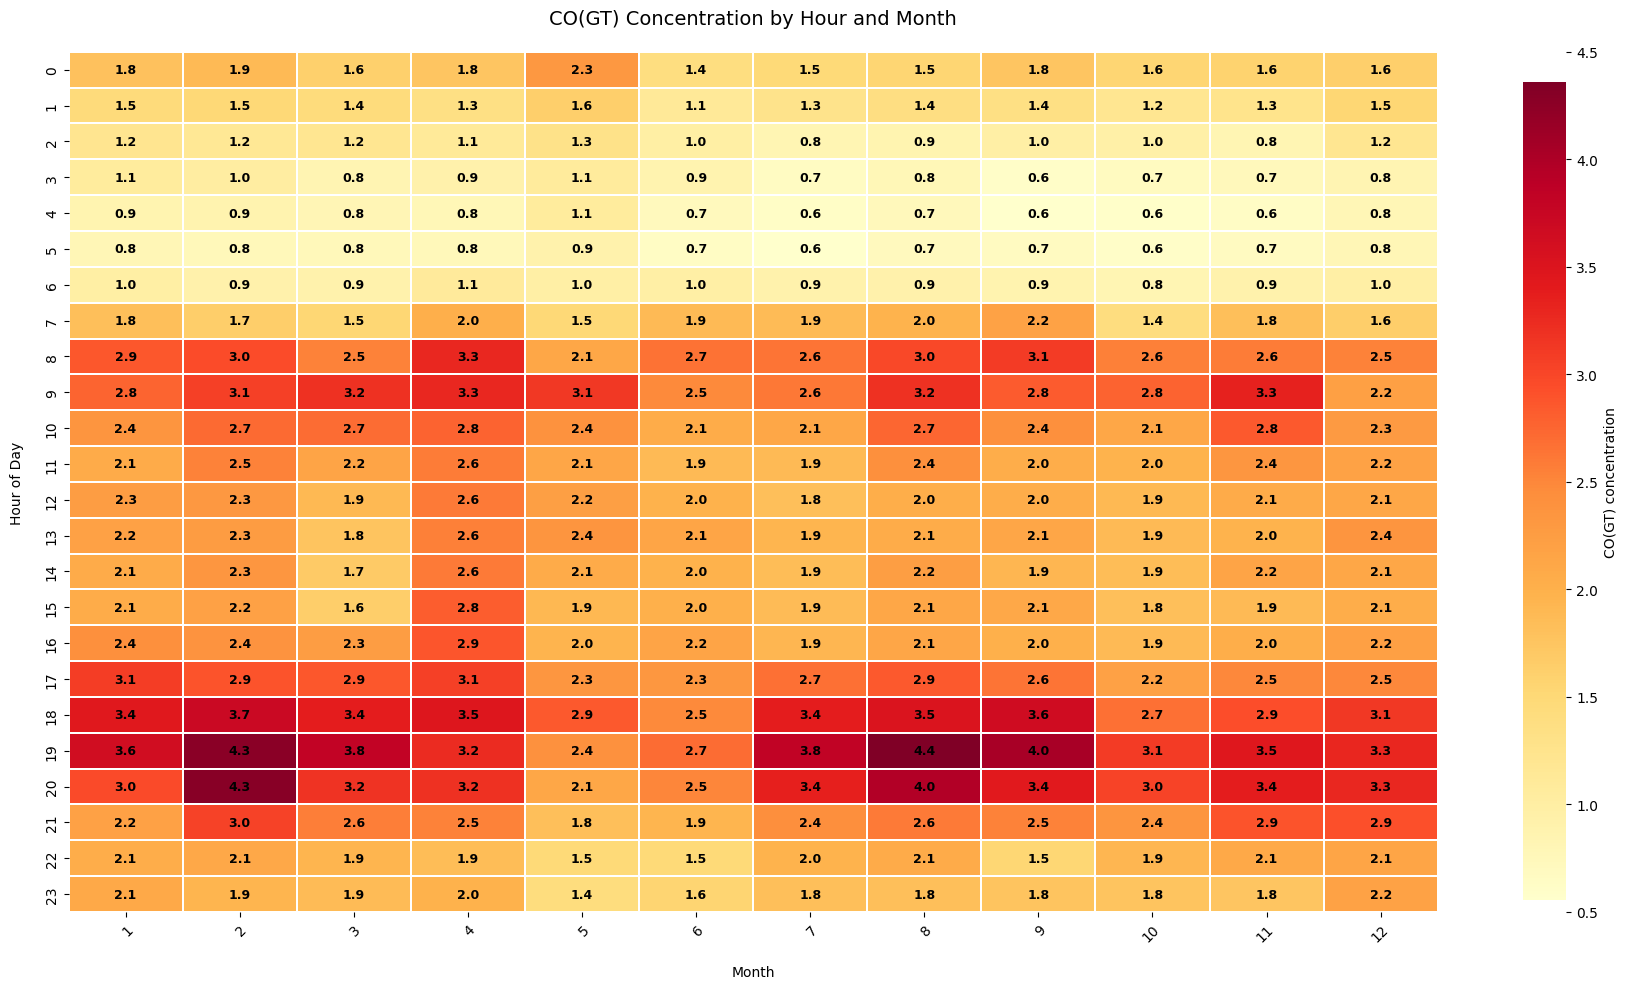

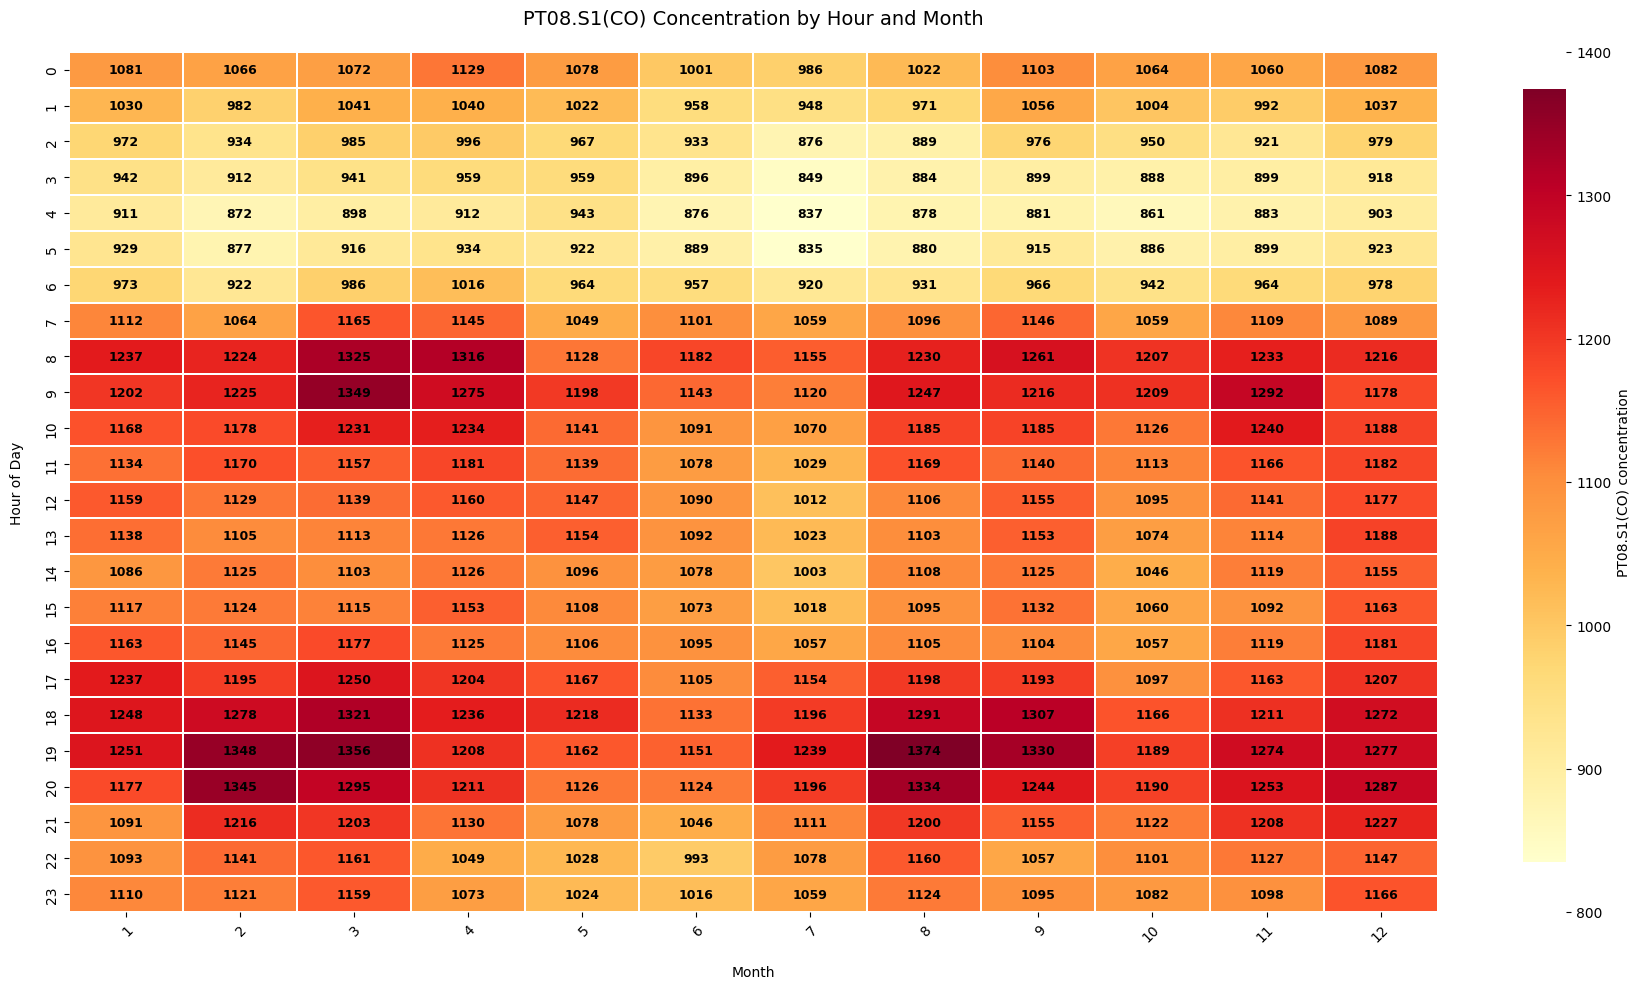

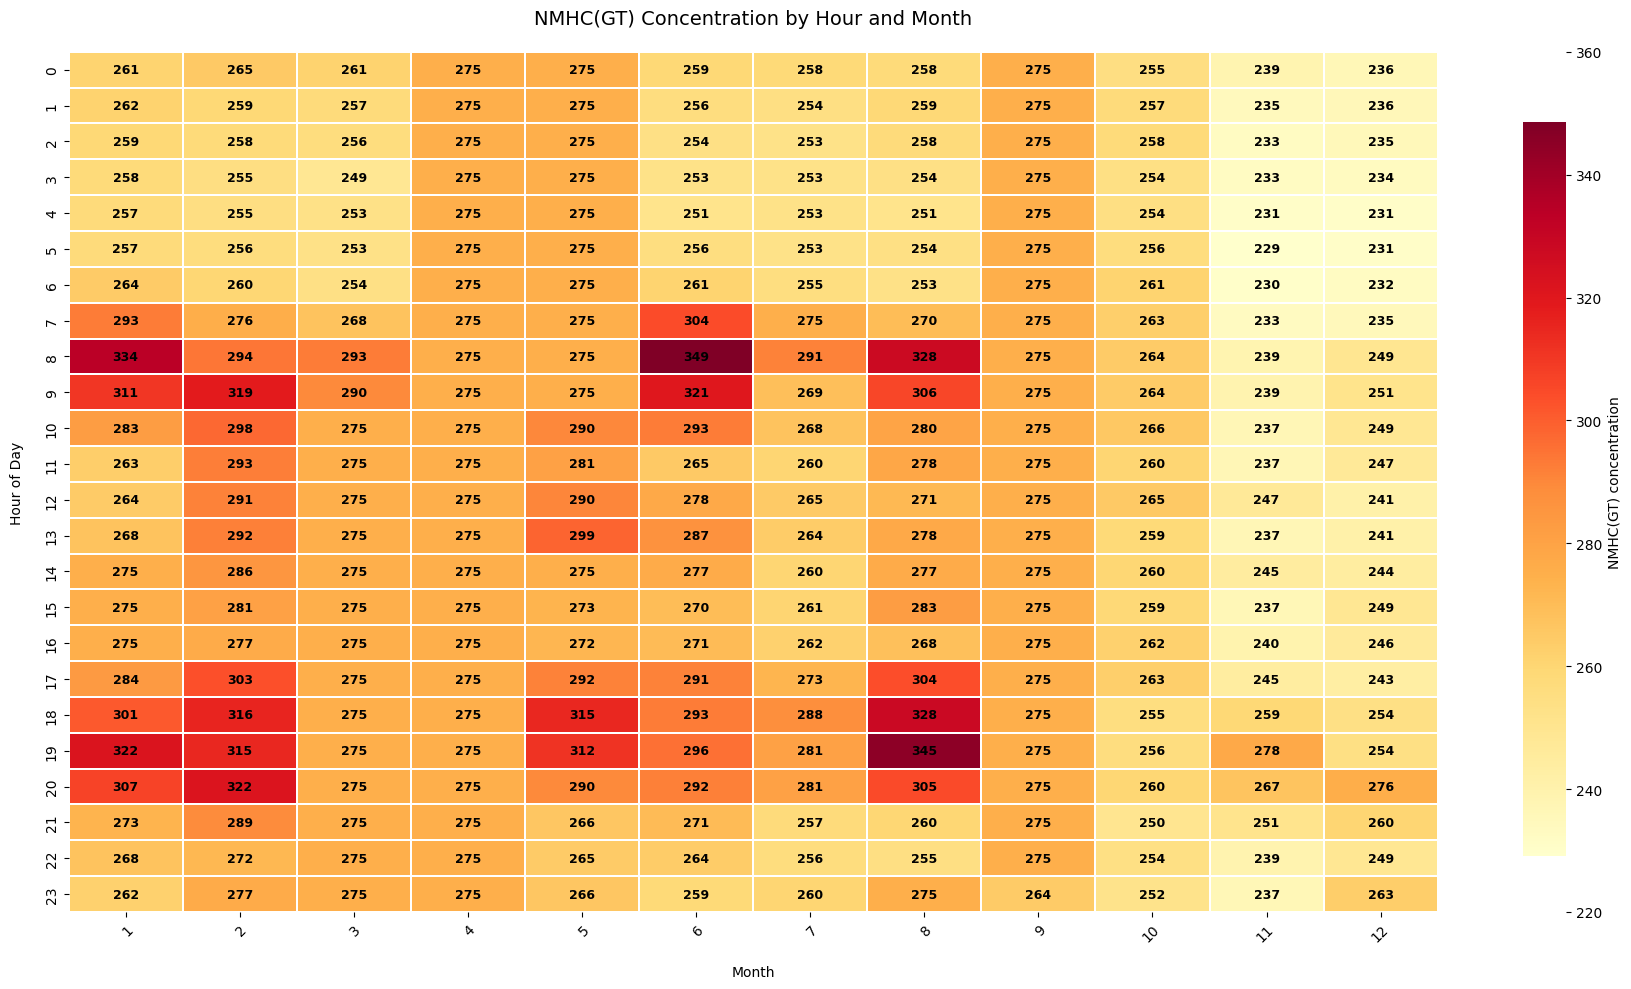

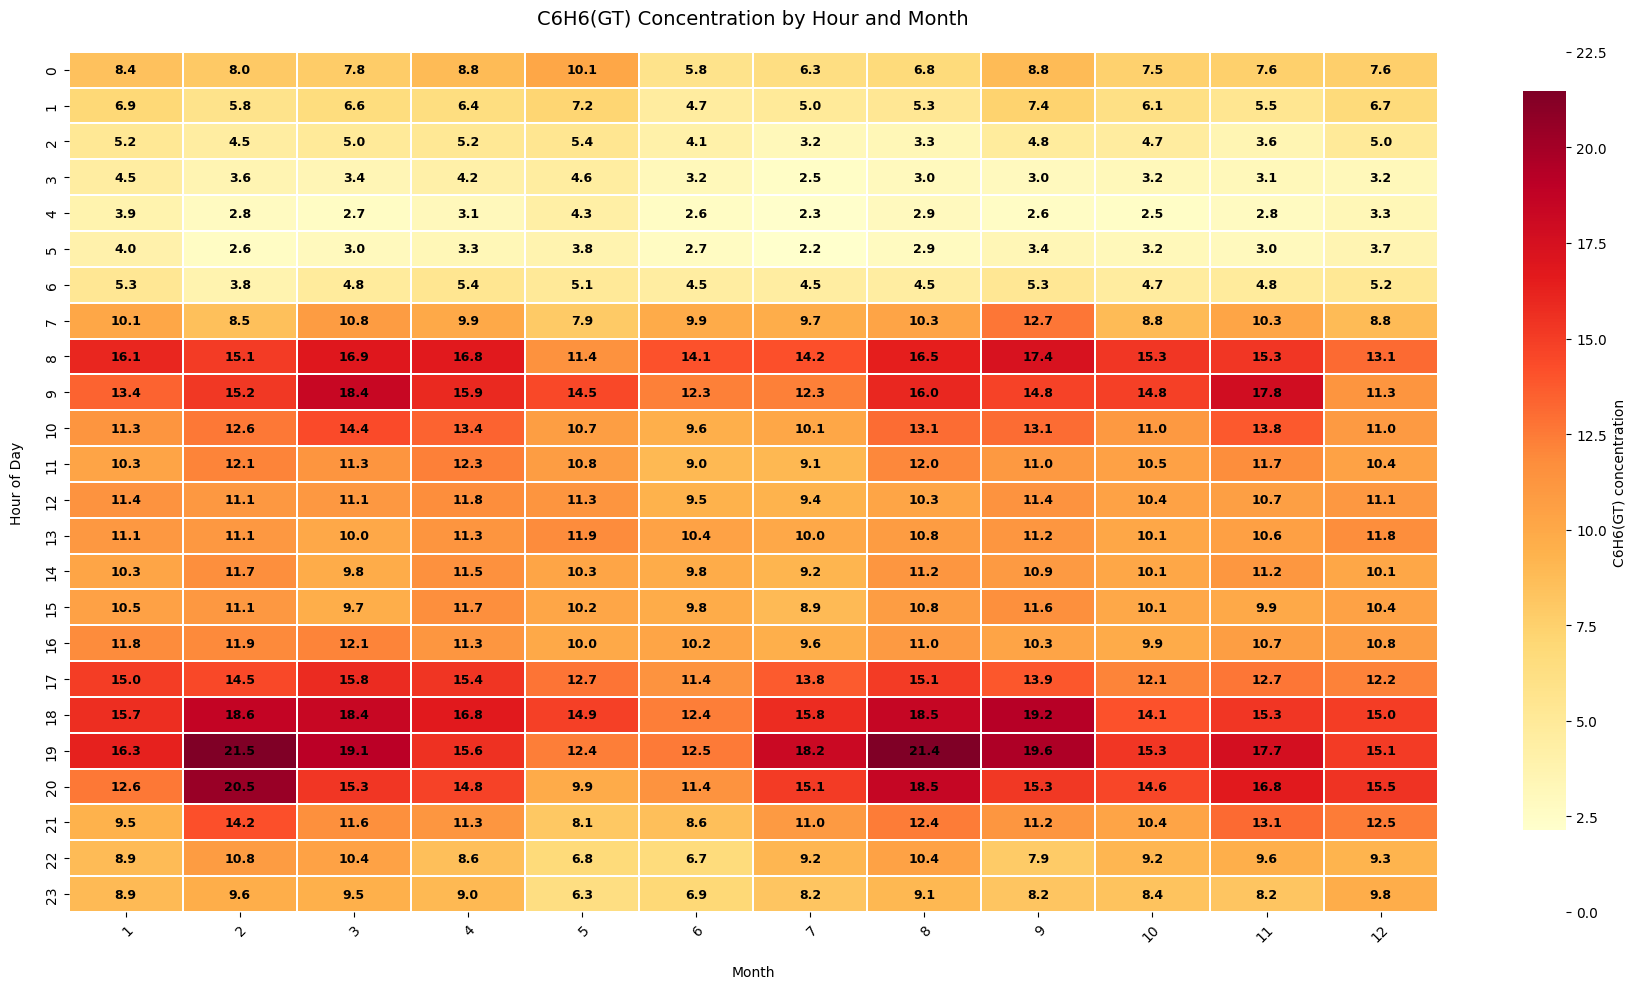

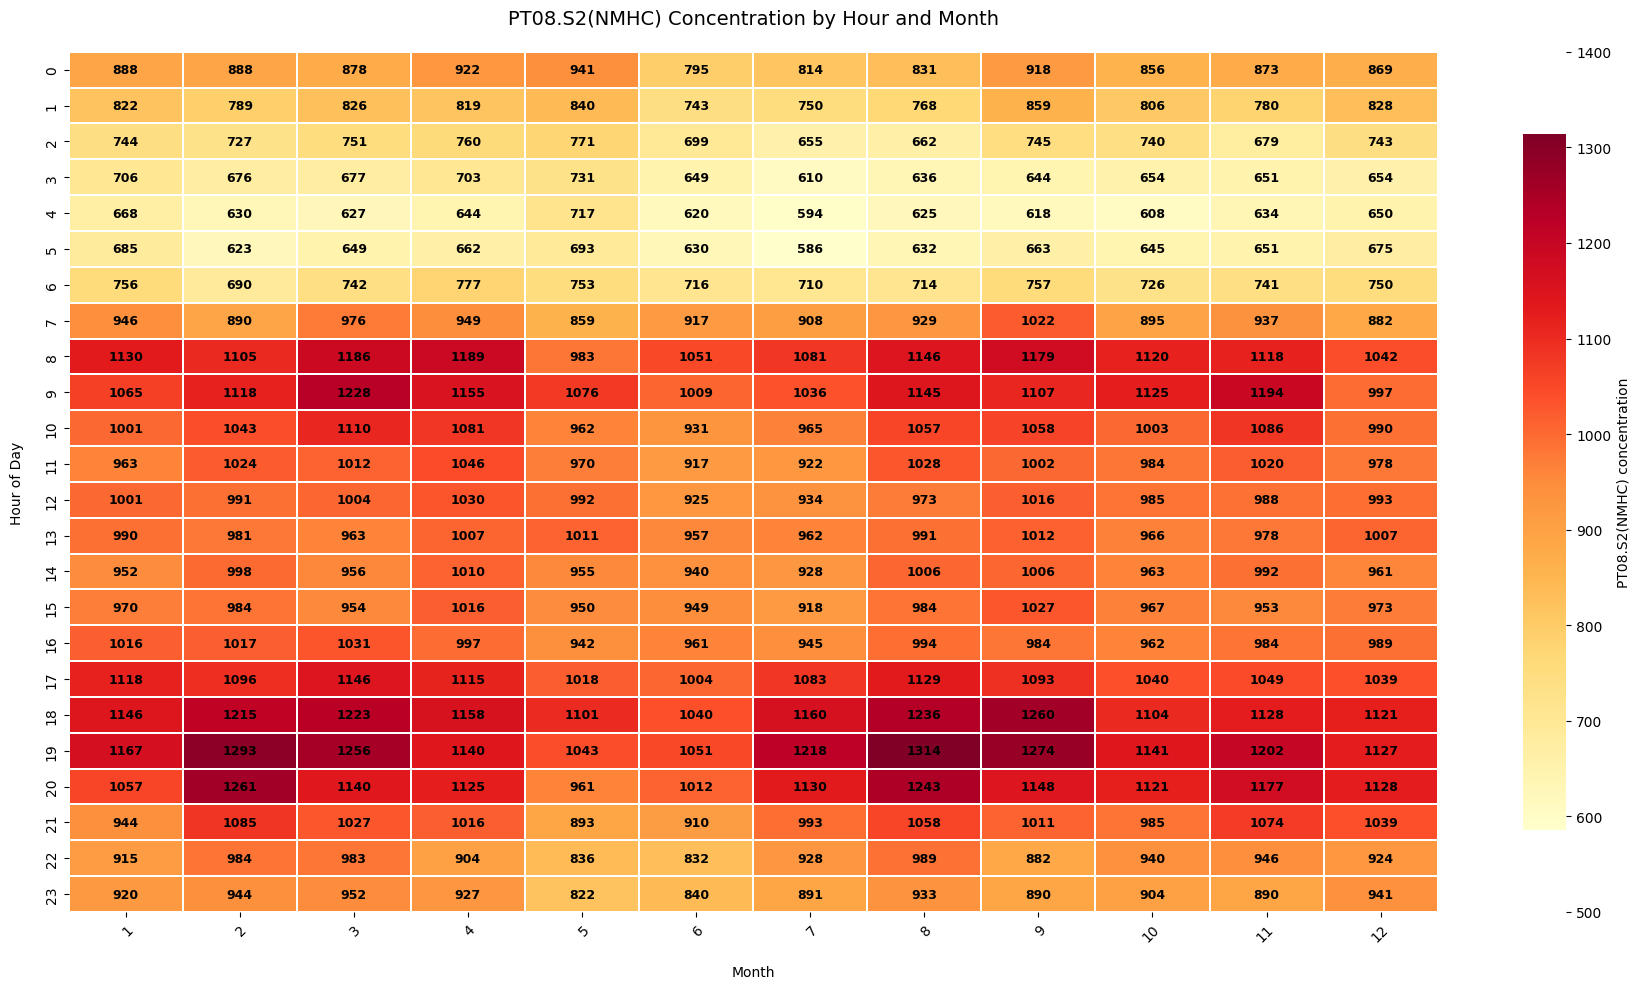

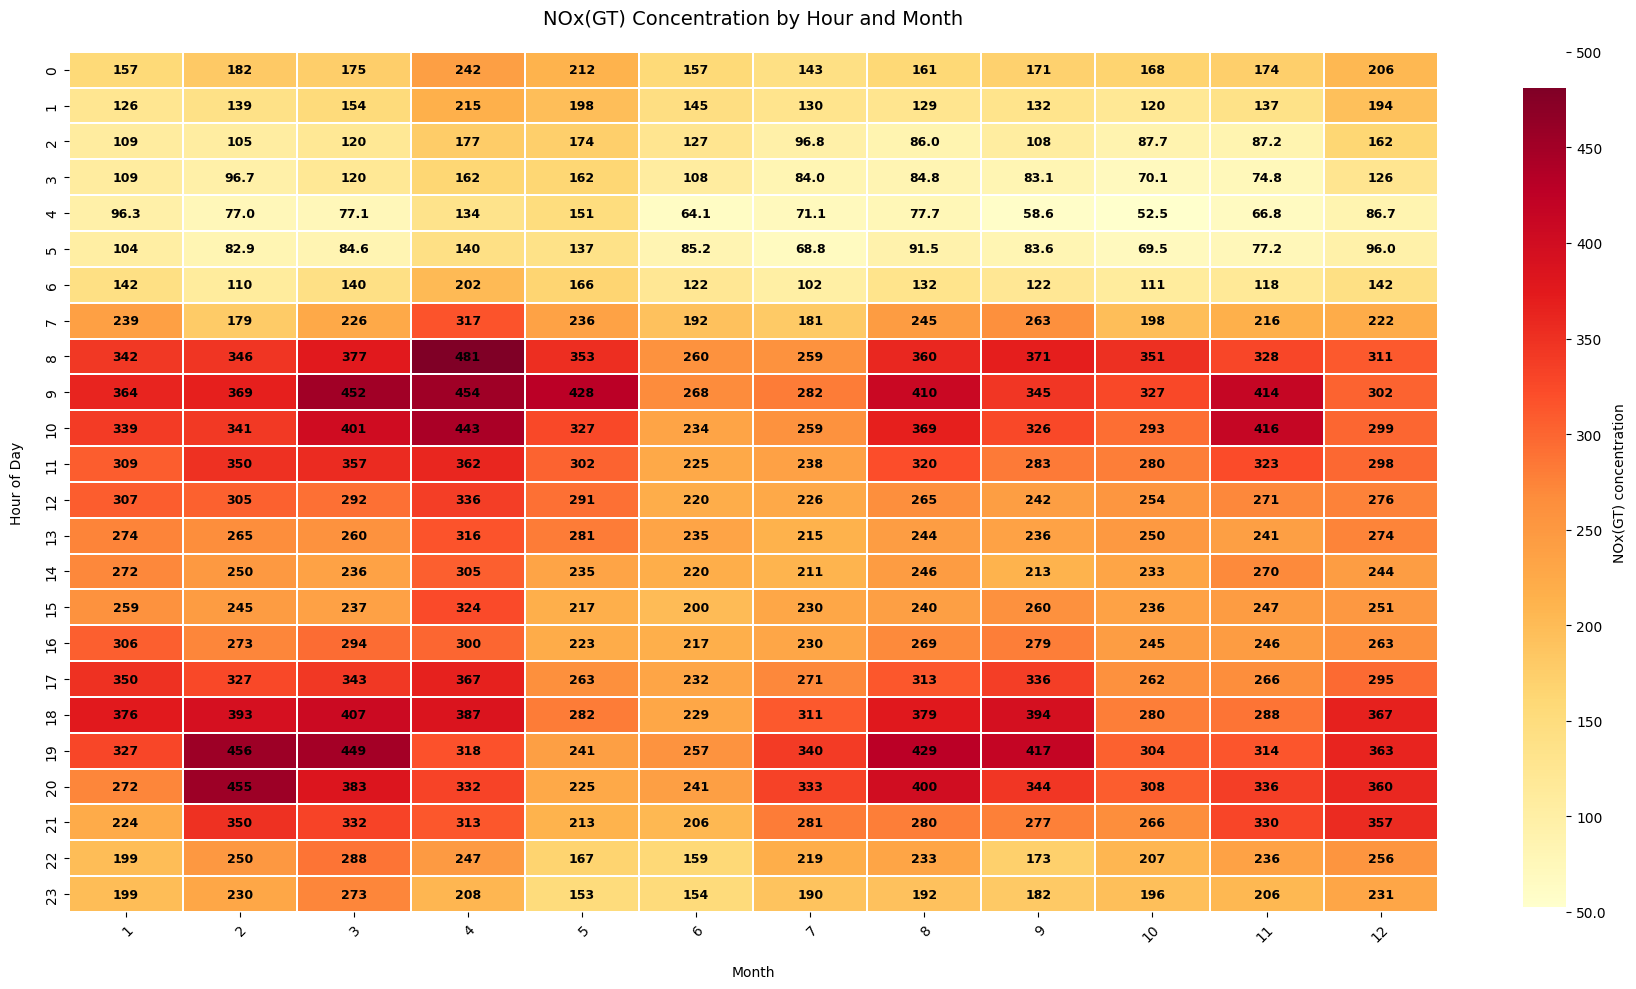

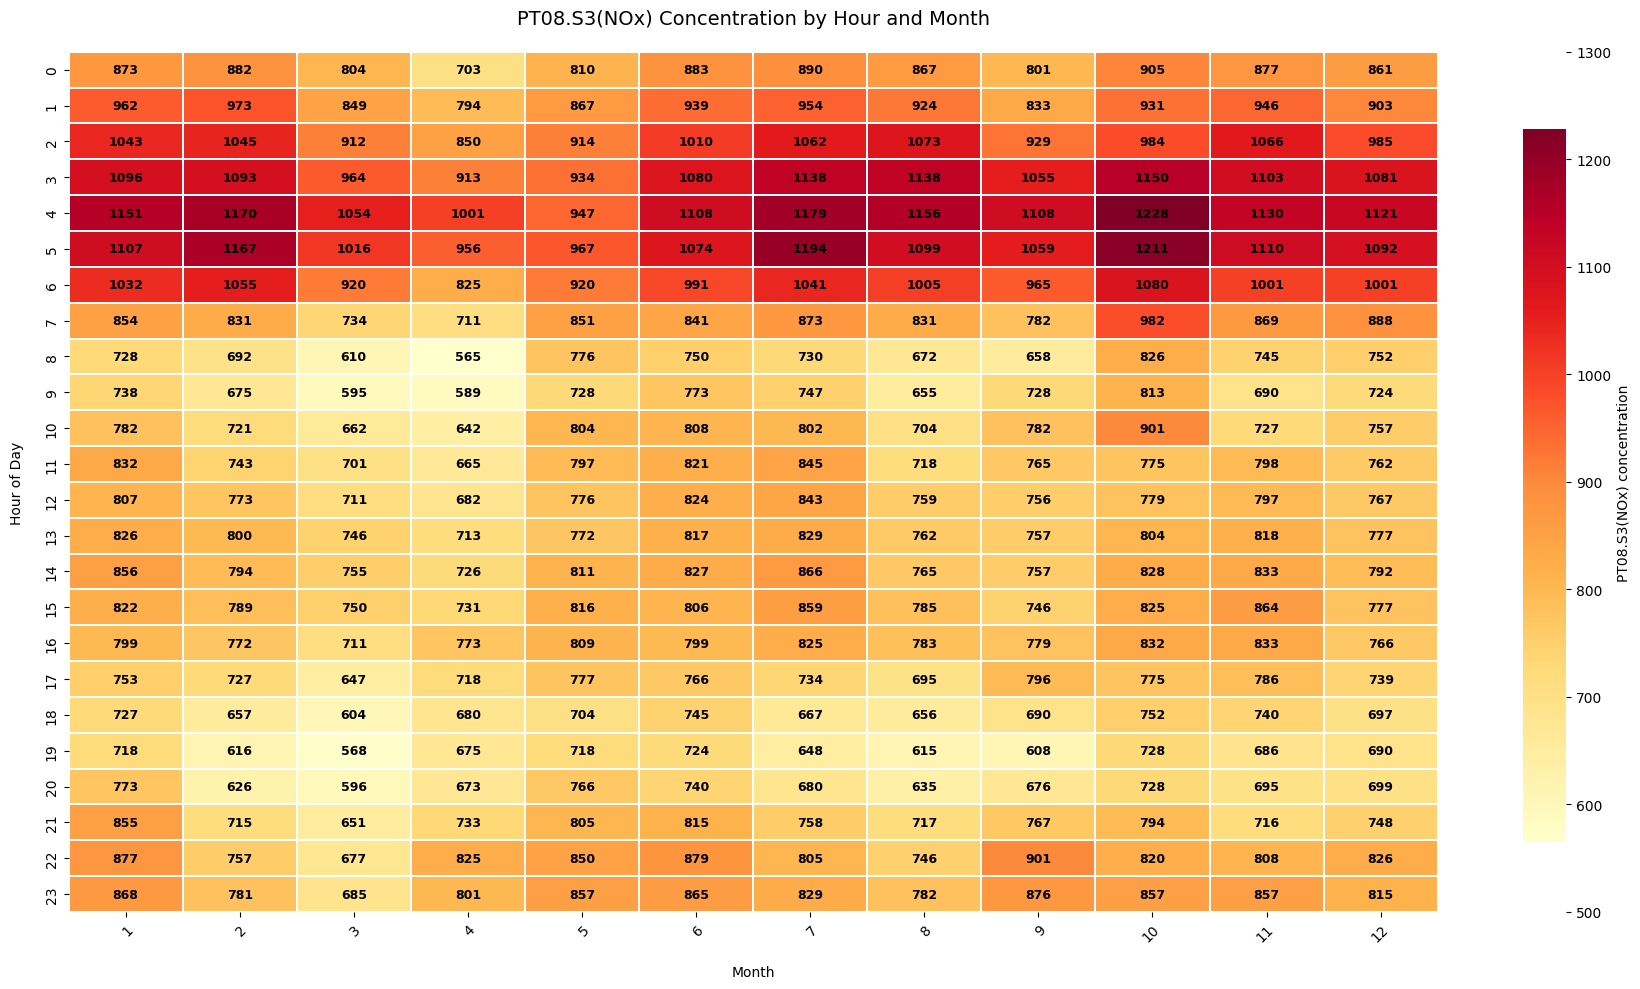

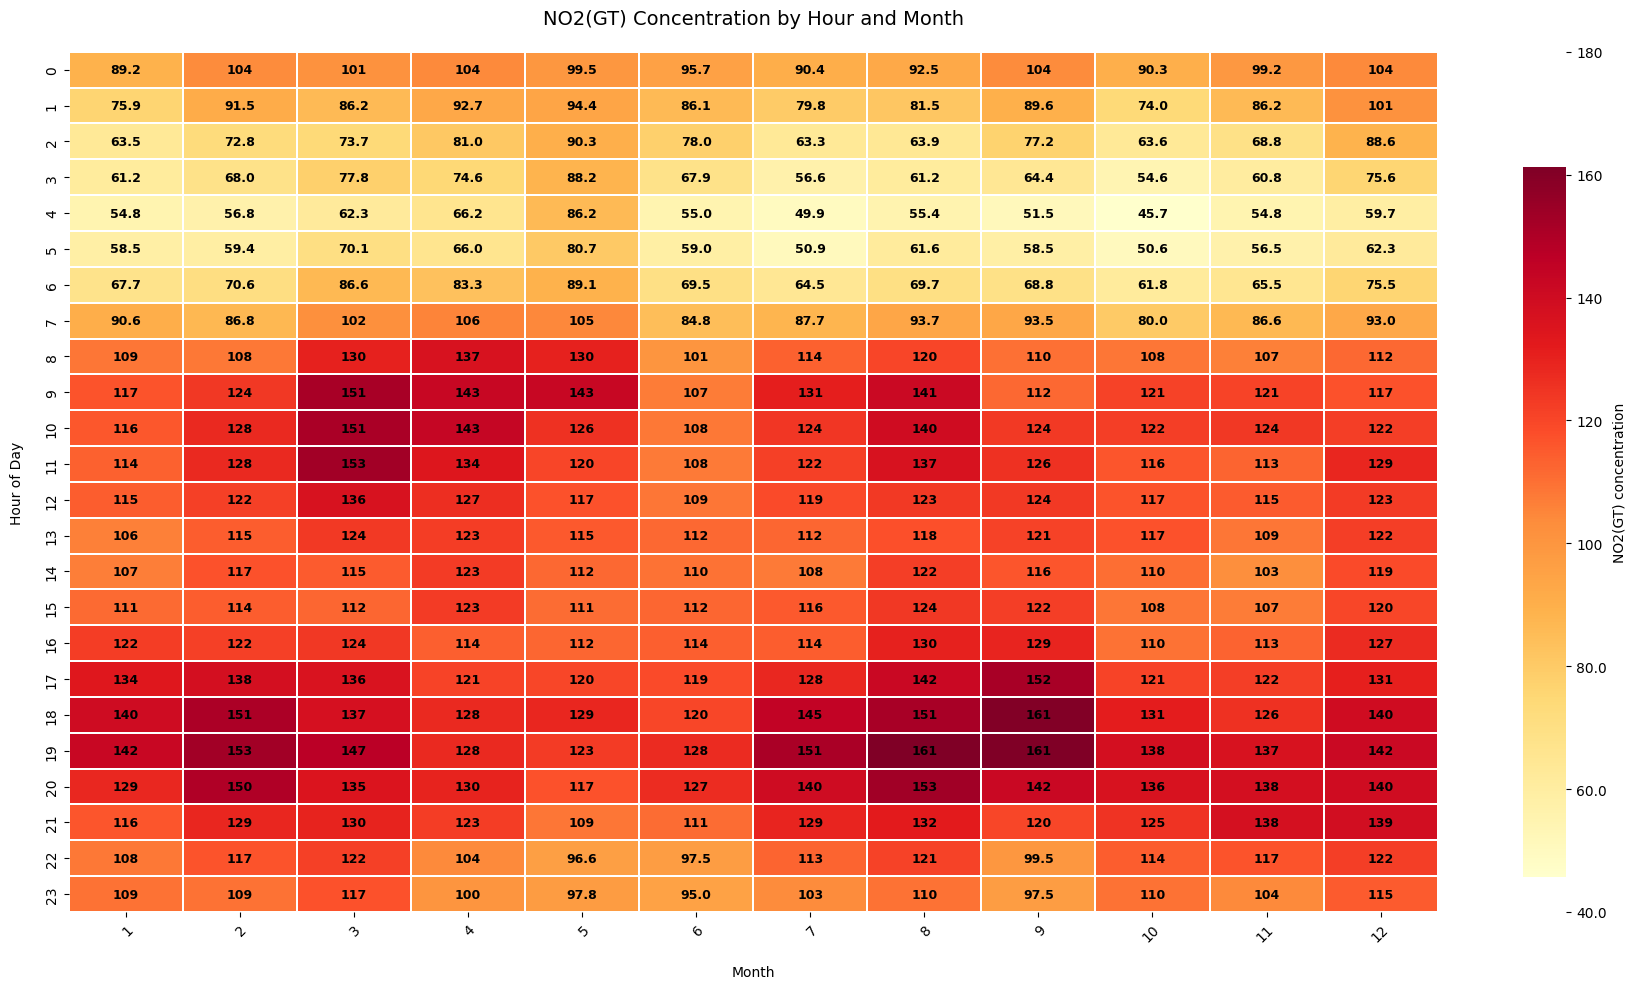

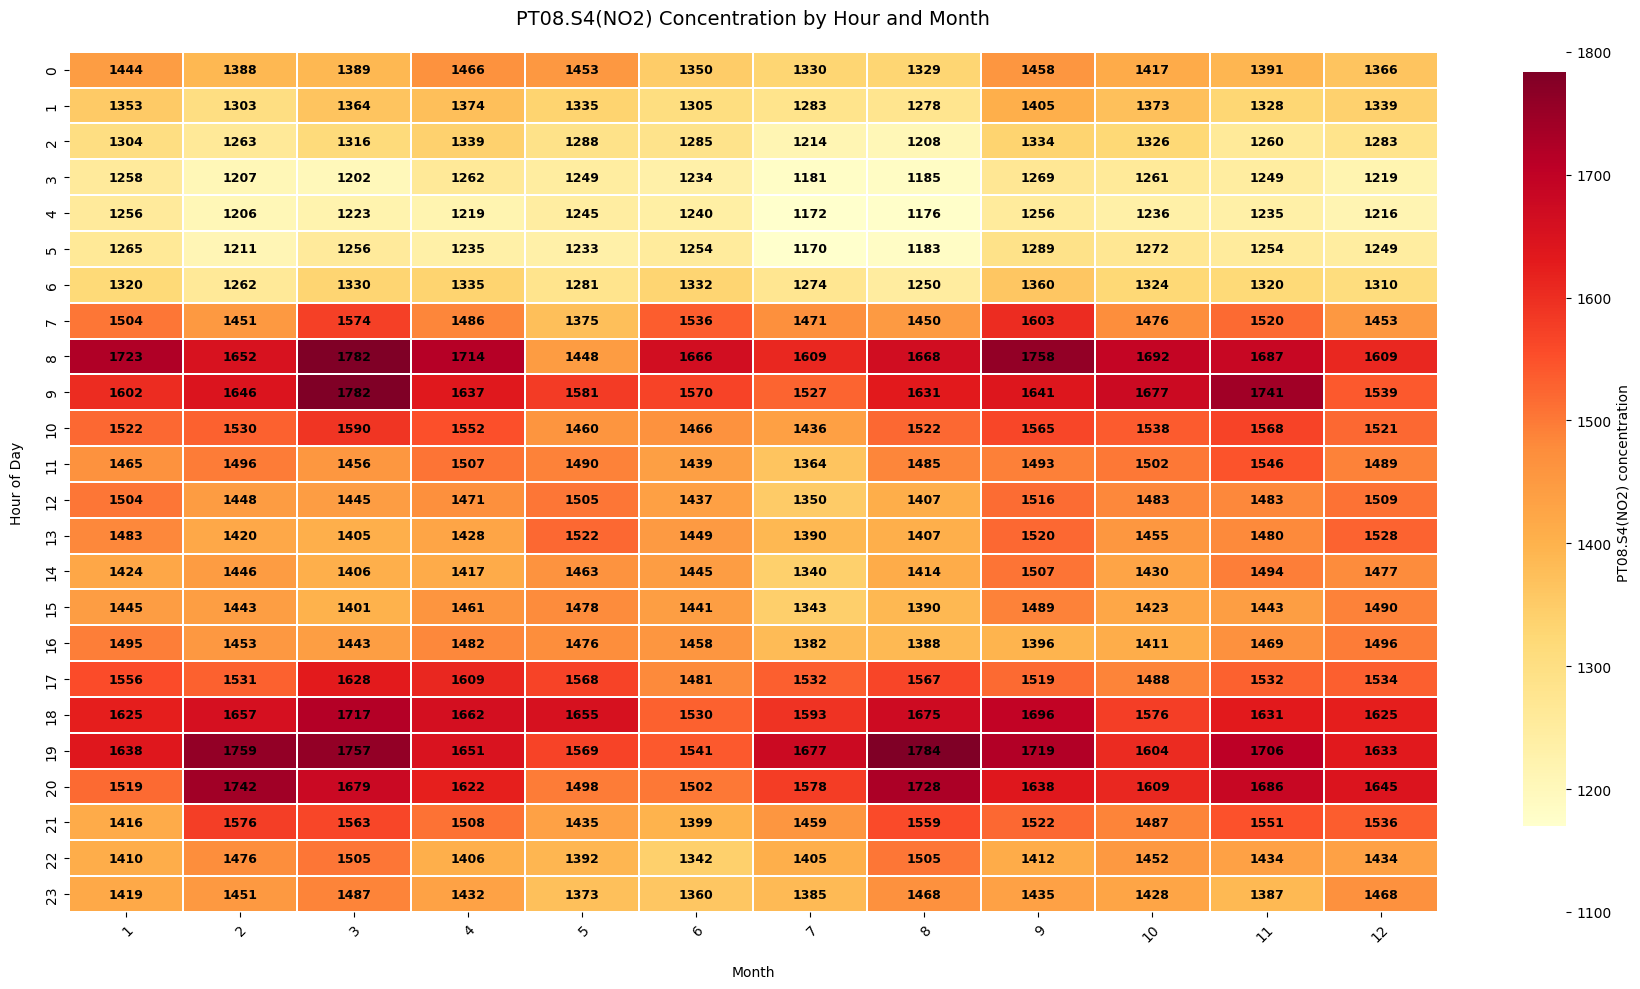

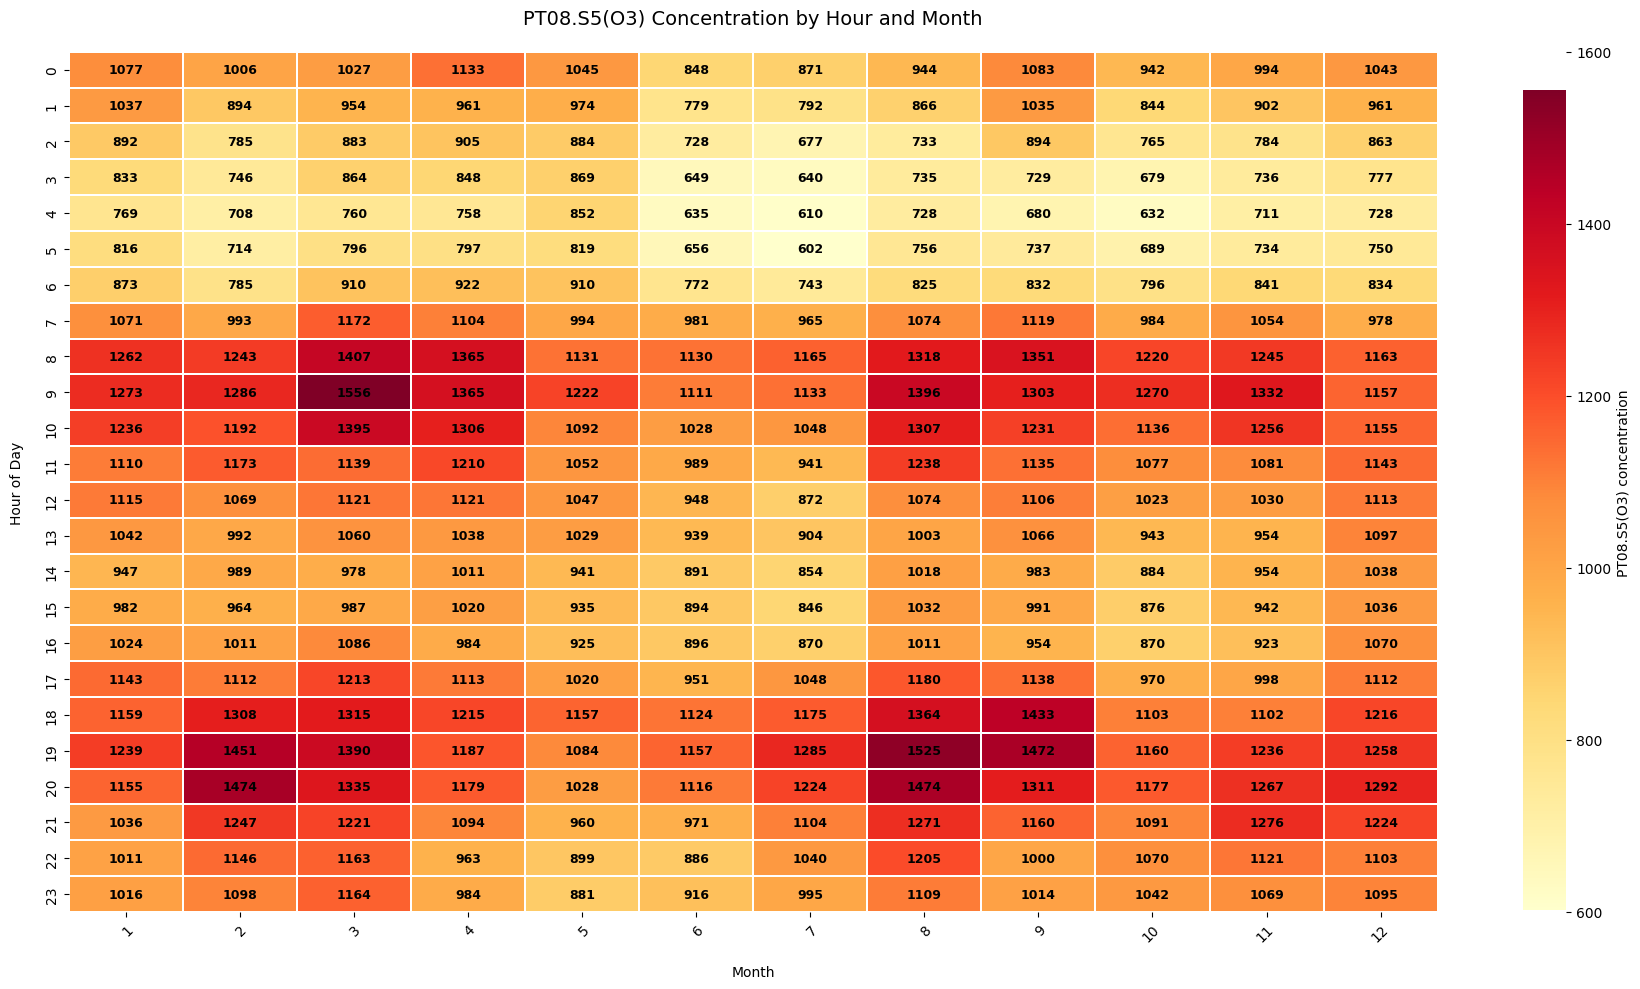

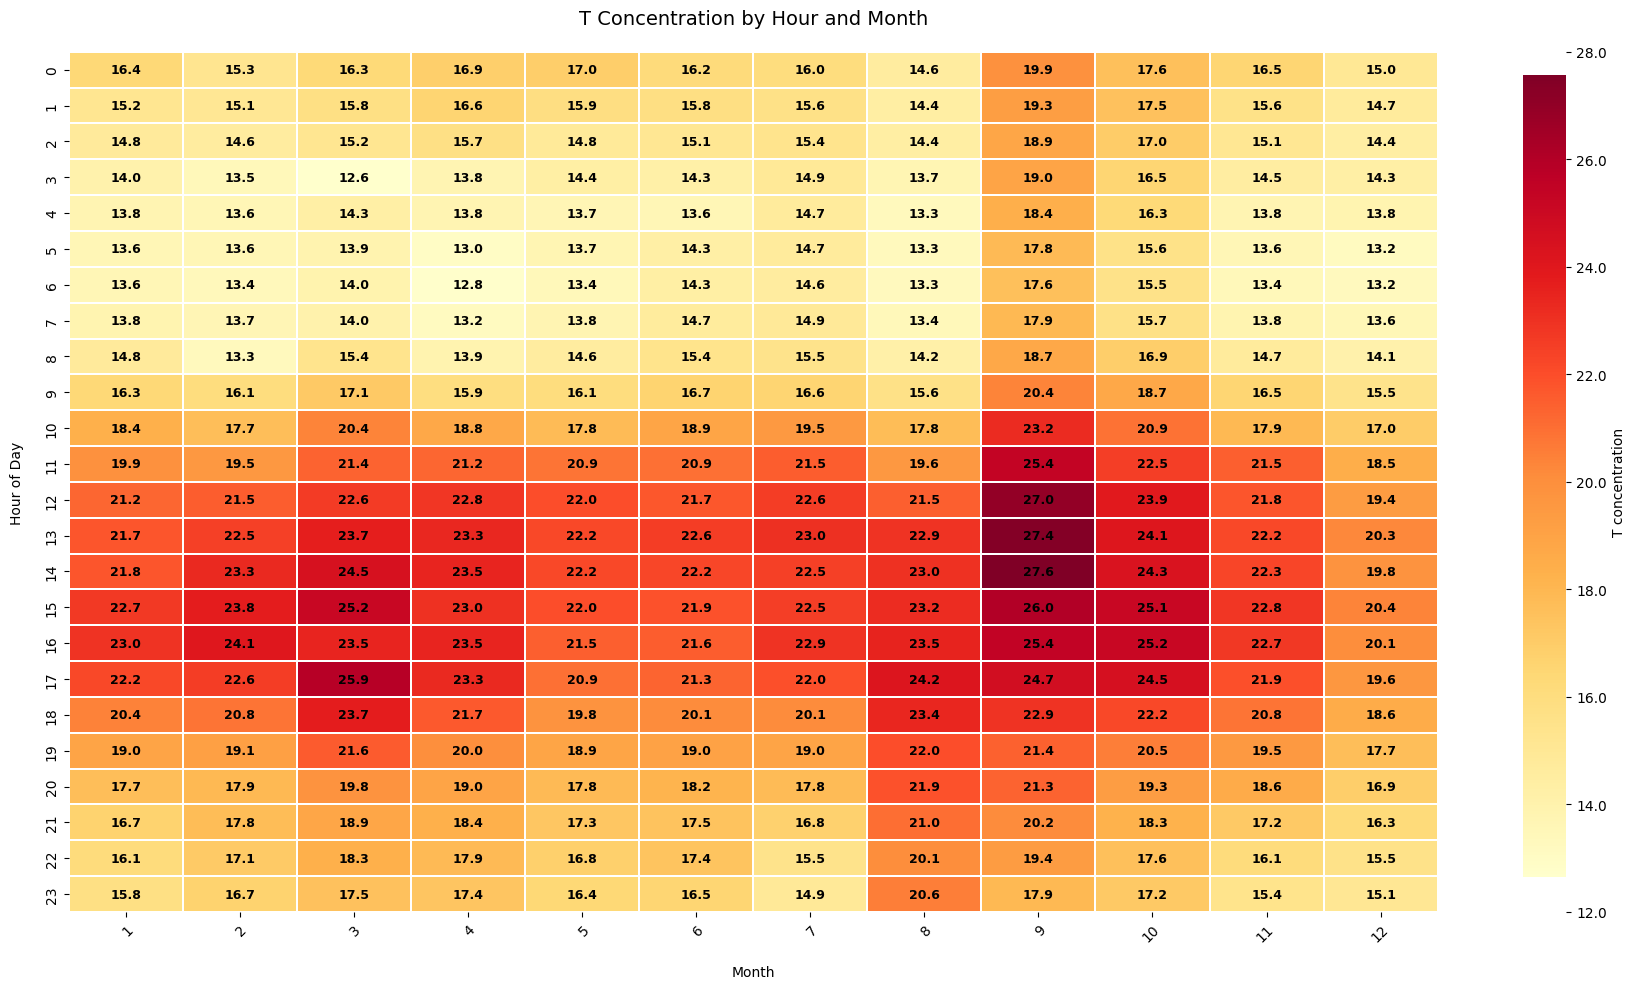

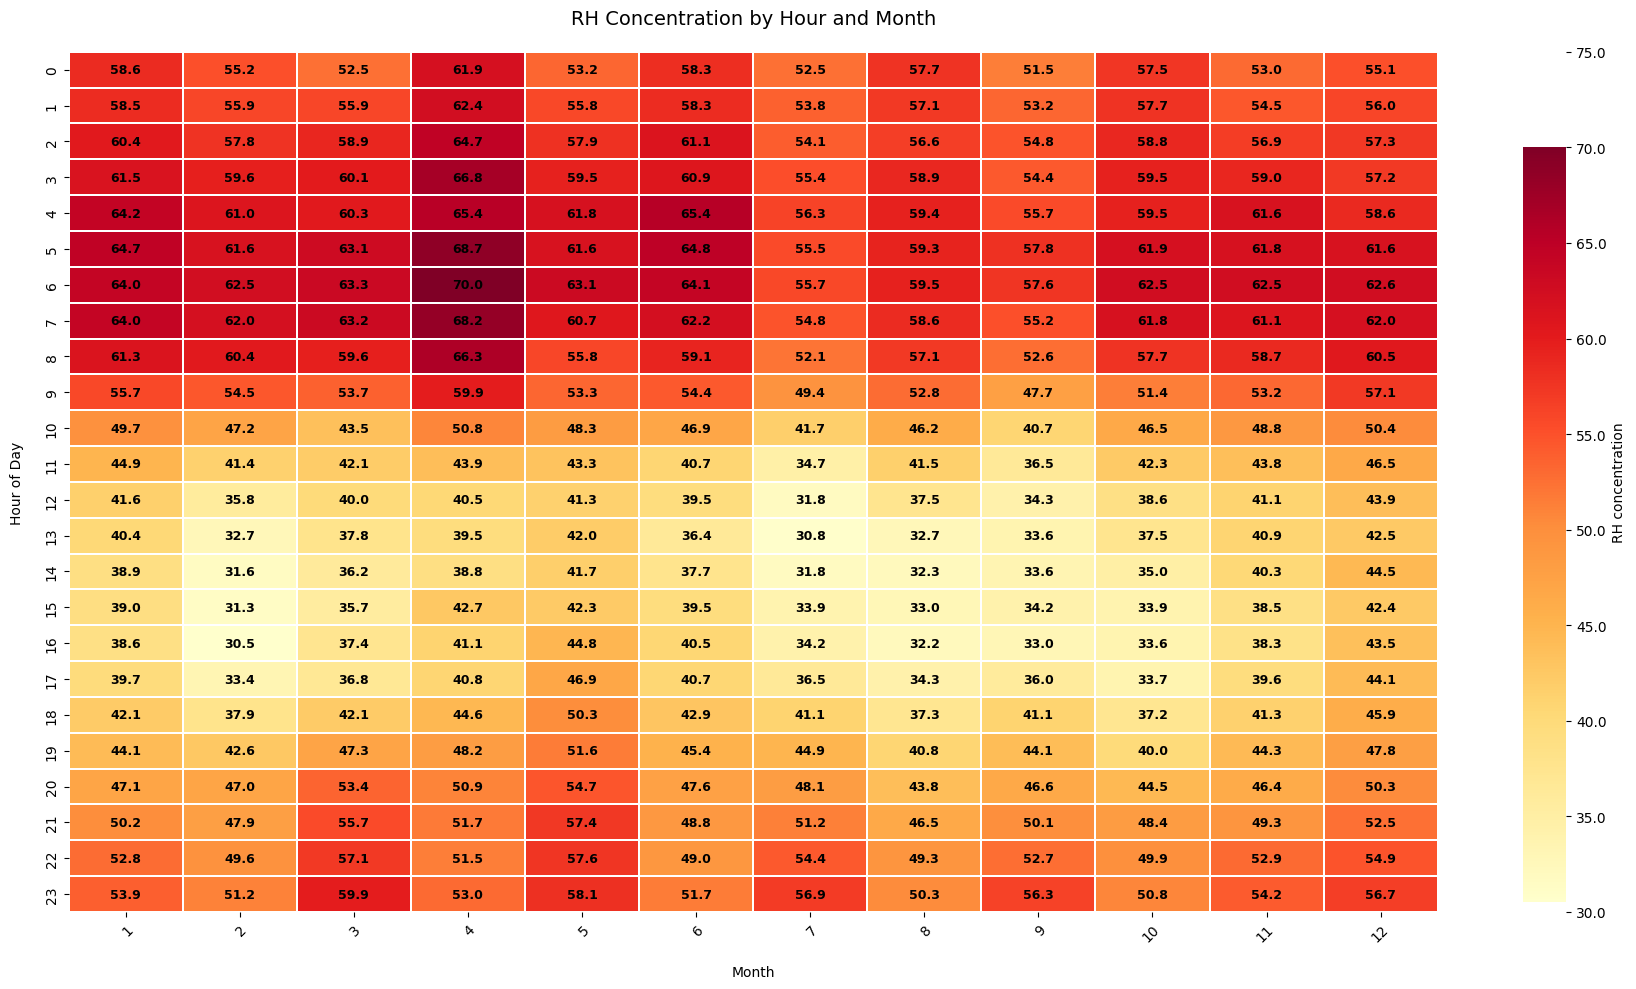

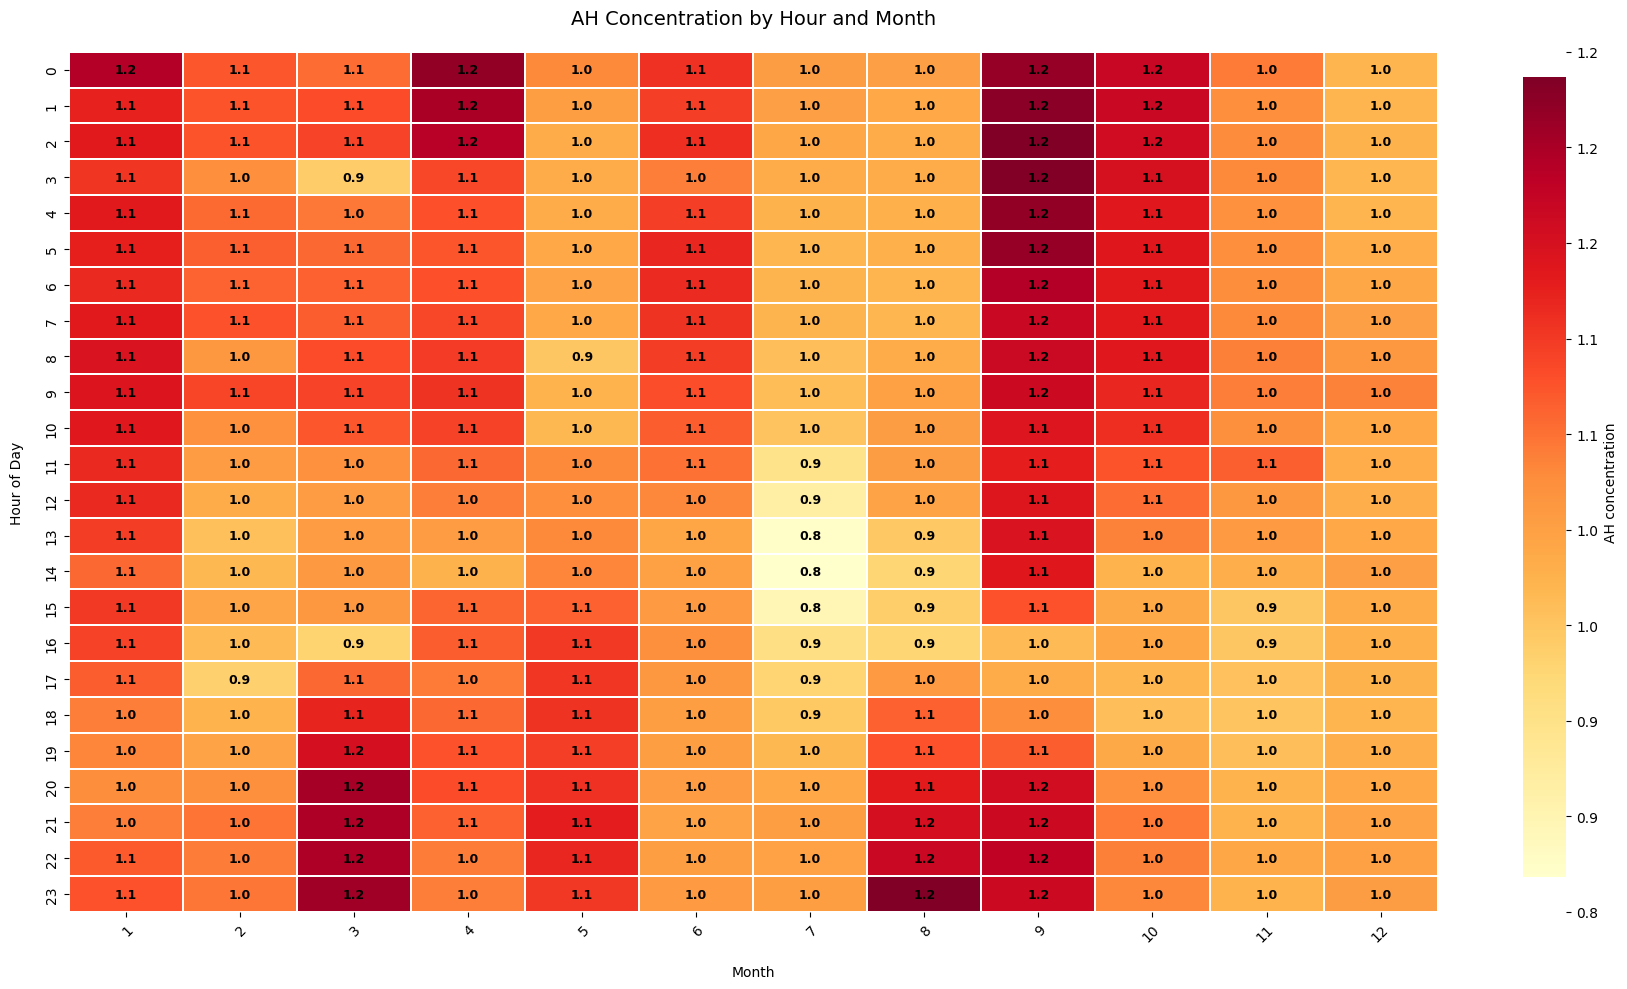

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

air_quality_df['Hour'] = air_quality_df['Time'].str.split(':').str[0].astype(int)
air_quality_df['Month'] = air_quality_df['Date'].dt.month

# List of all pollutant columns
pollutants = [
    'CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)',
    'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)',
    'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)',
    'PT08.S5(O3)', 'T', 'RH', 'AH'
]

# Create heatmaps for each pollutant
for pollutant in pollutants:
    if pollutant in air_quality_df.columns:
        # Create a larger figure
        plt.figure(figsize=(18, 10))

        # Create hour x month matrix
        heatmap_data = air_quality_df.pivot_table(
            index='Hour',
            columns='Month',
            values=pollutant,
            aggfunc='mean'
        )

        # Create custom annotations - decimals for <100, integers for >=100
        annotations = np.where(heatmap_data < 100,
                             heatmap_data.round(1).astype(str),
                             heatmap_data.round(0).astype(int).astype(str))

        # Plot heatmap with optimized settings
        ax = sns.heatmap(
            heatmap_data,
            cmap='YlOrRd',
            annot=annotations,
            fmt="",
            annot_kws={
                'size': 9,
                'weight': 'bold',
                'color': 'black'
            },
            cbar_kws={'label': f'{pollutant} concentration'},
            linewidths=0.3,
            square=False,
            vmin=heatmap_data.min().min(),
            vmax=heatmap_data.max().max()
        )

        # Improve label readability
        ax.set_xticklabels(ax.get_xticklabels(),
                          rotation=45,
                          ha='right',
                          rotation_mode='anchor')

        # Adjust colorbar tick formatting similarly
        cbar = ax.collections[0].colorbar
        cbar.set_ticks([t for t in cbar.get_ticks()])
        cbar.set_ticklabels([f"{t:.1f}" if t < 100 else f"{int(t)}"
                           for t in cbar.get_ticks()])

        # Add padding and titles
        plt.title(f'{pollutant} Concentration by Hour and Month',
                 pad=20,
                 fontsize=14)
        plt.xlabel('Month', labelpad=15)
        plt.ylabel('Hour of Day', labelpad=15)

        # Adjust layout
        plt.tight_layout()
        plt.show()

Analsis

Some things of note during EDA. First, pollutants peak during rush hours and vary by season. There is also a strong correlation between sensor readings and polutants. Furthermore, there are missing data and outliers which require more robust processesing. This means that the model should have time features and handle multicollinearity. I decided using tree based models will be the best since it captures non-linear data and temporal effects.

#Models


In [ ]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

# Feature Engineering
air_quality_df['CO_lag_1h'] = air_quality_df['CO(GT)'].shift(1)
air_quality_df['NO2_lag_1h'] = air_quality_df['NO2(GT)'].shift(1)
air_quality_df.dropna(inplace=True)

# Define Features/Targets
features = ['Hour_sin', 'Hour_cos', 'Month', 'T', 'RH', 'PT08.S1(CO)', 'CO_lag_1h', 'NO2_lag_1h']
X = air_quality_df[features]

# Separate targets
y_co = air_quality_df['CO(GT)']
y_no2 = air_quality_df['NO2(GT)']

# Log-transform targets to handle skew
y_co_log = np.log1p(y_co)
y_no2_log = np.log1p(y_no2)

# Time-series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Initialize models
models = {
    'Random Forest': RandomForestRegressor(n_estimators=200, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=150, learning_rate=0.1, random_state=42),
    'Linear Regression': LinearRegression()
}

# Store metrics for all models
all_metrics = {
    'CO(GT)': {name: {'RMSE': [], 'MAE': [], 'R²': []} for name in models},
    'NO2(GT)': {name: {'RMSE': [], 'MAE': [], 'R²': []} for name in models}
}

# Standardize features for Linear Regression
scaler = StandardScaler()

for train_idx, test_idx in tscv.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_co_train, y_co_test = y_co_log.iloc[train_idx], y_co_log.iloc[test_idx]
    y_no2_train, y_no2_test = y_no2_log.iloc[train_idx], y_no2_log.iloc[test_idx]

    # Scale features for Linear Regression
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    for name, model in models.items():
        # Special handling for Linear Regression (needs scaling)
        if name == 'Linear Regression':
            X_tr, X_te = X_train_scaled, X_test_scaled
        else:
            X_tr, X_te = X_train, X_test

        # Train/Test for CO
        model.fit(X_tr, y_co_train)
        y_co_pred = model.predict(X_te)
        all_metrics['CO(GT)'][name]['RMSE'].append(np.sqrt(mean_squared_error(np.expm1(y_co_test), np.expm1(y_co_pred))))
        all_metrics['CO(GT)'][name]['MAE'].append(mean_absolute_error(np.expm1(y_co_test), np.expm1(y_co_pred)))
        all_metrics['CO(GT)'][name]['R²'].append(r2_score(y_co_test, y_co_pred))

        # Train/Test for NO₂
        model.fit(X_tr, y_no2_train)
        y_no2_pred = model.predict(X_te)
        all_metrics['NO2(GT)'][name]['RMSE'].append(np.sqrt(mean_squared_error(np.expm1(y_no2_test), np.expm1(y_no2_pred))))
        all_metrics['NO2(GT)'][name]['MAE'].append(mean_absolute_error(np.expm1(y_no2_test), np.expm1(y_no2_pred)))
        all_metrics['NO2(GT)'][name]['R²'].append(r2_score(y_no2_test, y_no2_pred))

# Calculate average metrics
results = {}
for target in all_metrics:
    results[target] = {}
    for model in all_metrics[target]:
        results[target][model] = {
            'RMSE': np.mean(all_metrics[target][model]['RMSE']),
            'MAE': np.mean(all_metrics[target][model]['MAE']),
            'R²': np.mean(all_metrics[target][model]['R²'])
        }

# Display results
for target in results:
    print(f"\n{target} Prediction Results:")
    print("-"*50)
    for model in results[target]:
        print(f"\n{model}:")
        print(f"  RMSE: {results[target][model]['RMSE']:.2f} µg/m³")
        print(f"  MAE: {results[target][model]['MAE']:.2f} µg/m³")
        print(f"  R²: {results[target][model]['R²']:.2f}")


CO(GT) Prediction Results:
--------------------------------------------------

Random Forest:
  RMSE: 0.55 µg/m³
  MAE: 0.37 µg/m³
  R²: 0.83

Gradient Boosting:
  RMSE: 0.55 µg/m³
  MAE: 0.38 µg/m³
  R²: 0.83

Linear Regression:
  RMSE: 0.66 µg/m³
  MAE: 0.43 µg/m³
  R²: 0.79

NO2(GT) Prediction Results:
--------------------------------------------------

Random Forest:
  RMSE: 21.11 µg/m³
  MAE: 15.42 µg/m³
  R²: 0.78

Gradient Boosting:
  RMSE: 20.82 µg/m³
  MAE: 15.02 µg/m³
  R²: 0.78

Linear Regression:
  RMSE: 31.40 µg/m³
  MAE: 18.41 µg/m³
  R²: 0.75


**Feature Engineering & Selection:**
Temporal Features: hour and month were extracted from time and date to capture Diurnal patters such as rush hour peaks and seasonal variations in pollution. Tree based models benifit from these explicit temporal features

Also, I created a temperature * hrelative humidity interaction since ozone formation depends on both heat and humidity

Finally, I added a 1 hour lag feature for pollutants to account for autocorrection and to reflect the presistance of pollution events

Transformations: dropped columns with over 50% missing data

I ended up chossing Hour_sin, Hour_cos, Month, T, RH, Temp_x_Rh, PT0.8.S1(CO) and NO2(GT)_lag1.




**Model Tuning, Validation, and Evaluation:**
I looked at 3 different approaces: Random Forest since its robust to outliers and handles non-linear reltaionships, Gradiant boosting for possibly higher accuracy at the cost of speed, and Linear Regression for the baseline.
The best model was selected based on accuracy and efficiency

The metrics are RMSE, MAE, and R^2. RMSE is prioritized since it penalizes large errors which is important in real-life scenerios

Results: for CO Prediction: Random forest outperformed linear regression by 4% and was around the same as Gradient Boosting
for NO2 prediction, Random forest outperformed Linear Regressiion by 3% and was around the same as Gradient Boosting.

Final Choice: I believe random forest is the best model since it its performance was matched with Gradient Boosting but is much faster and is more robust to multicollinearity.


#Conclusions

**Key Findings**:
During the exploratory data analysis, I found that pollutants exhibit temporal patterns, peaking during rush hours and varying by season. Also, strong correlations exist between sensor readings and pollutant levels, which suggests multicollinearity
Also, random forest achieved strong performance since it had 0.78 to 0.83 R^2. It alsos outperformed linear models by 15-31% in error reduction

**Problem Resolution**:
The model was effective in predicting harmful pollutant levels, which enables timely interventions. Some business impacts include cost savings through government optimizing policy decisions and industries adjusting emissions to avoid fines

**Deployment Strategy**:
We need real-time predictions for immediate alerts and weekly forecasts for long-term policy adjustments. We will need to retrain the model every 3-6 months to account for seasonal variations.

**Improvements**:
There could be more sensors in underrepresented areas to reduce bias and include weather data for better accuracy. Furthermore, there can be some model enhancements such as gradient boosting or deep learning.